In [1]:
import numpy as np
import obspy
from hydrophone_data_processing import load, useful_variables, plotting, signal_processing
import scipy.signal as signal
import pandas as pd
import matplotlib.dates as dates
import obspy.signal.trigger as trigger
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import config
from event_pipeline import Event
from obspy.imaging.spectrogram import spectrogram


def import_data(day, starttime, endtime):
    daypaths = useful_variables.make_hydrophone_data_paths(borehole='a', year=2019, julian_day=day)
    starttime = obspy.UTCDateTime(starttime)
    endtime = obspy.UTCDateTime(endtime)
    data = load.import_corrected_data_for_single_day(daypaths)
    data.trim(starttime=starttime, endtime=endtime)
    return data

In [2]:
day141 = import_data(day=141, starttime='2019-05-21T07:00:00.0Z', endtime='2019-05-21T09:00:00.0Z')

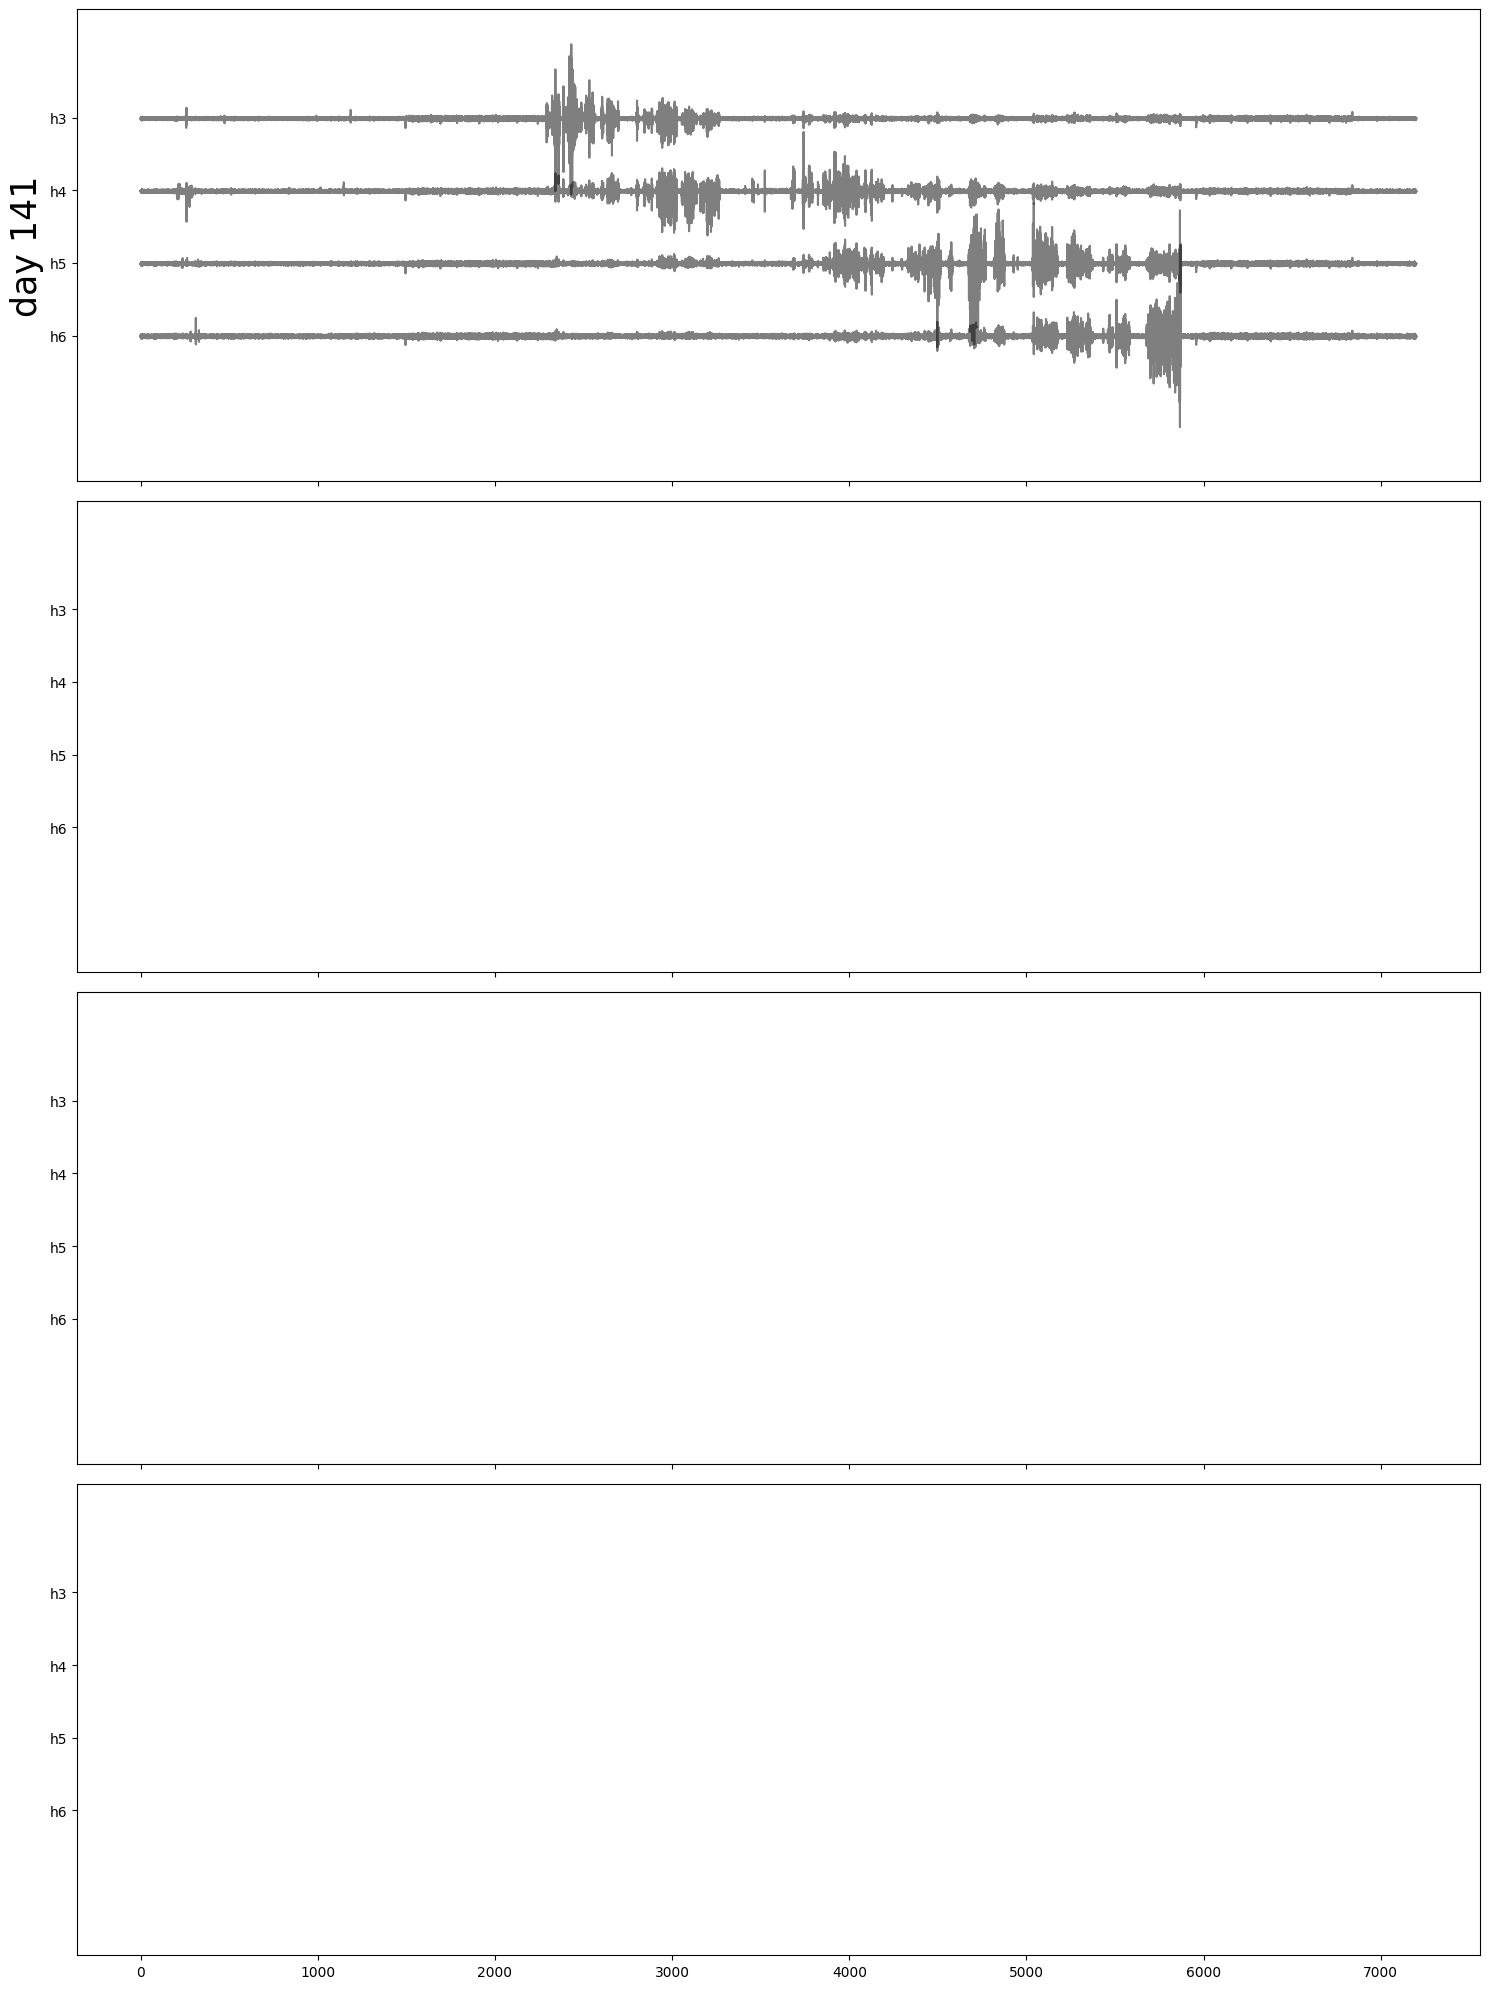

In [3]:
fig, ax = plt.subplots(4, 1, figsize=(15, 20), sharey=True, sharex=True)

def plot_waveform(ax, stream, day):
    times = np.array([tr.times() for tr in stream][2:])
    data = [tr.data for tr in stream][2:]
    n = 0
    for t, d in zip(times, data):
        ax.plot(t, d - n * 10, color='black', alpha=0.5)
        n+=1
        
    ax.set_ylabel('day ' + str(day), fontsize=25)

plot_waveform(ax=ax[0], stream=day141, day=141)
# plot_waveform(ax=ax[1], stream=day188, day=188)
# plot_waveform(ax=ax[2], stream=day197, day=197)
# plot_waveform(ax=ax[3], stream=day211, day=211)

ax[0].set_ylim(-50, 15)
ax[0].set_yticks([0, -10, -20, -30])
ax[0].set_yticklabels(['h3', 'h4', 'h5', 'h6'])

plt.tight_layout()

# fig.savefig('figures/raw_waveforms.pdf', bbox_inches='tight')

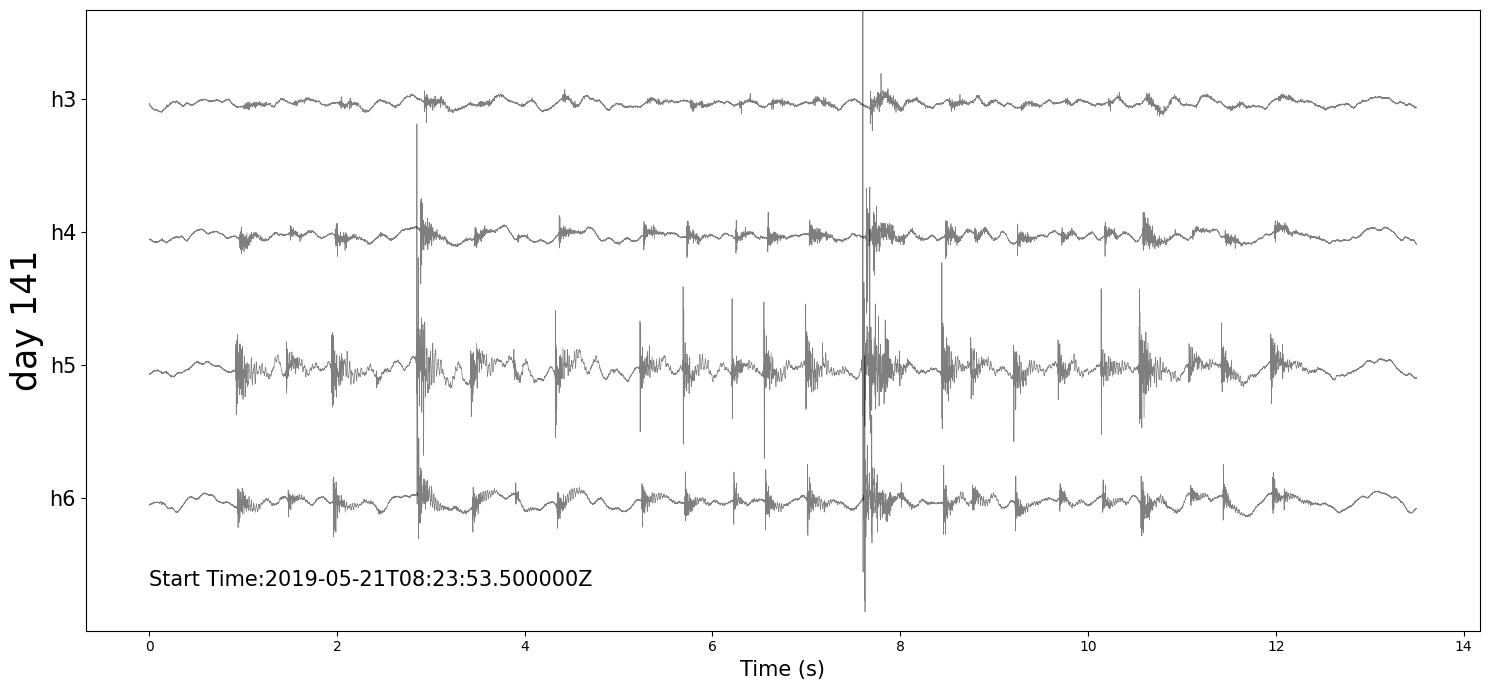

In [4]:
def plot_waveform(ax, stream, day):
    times = np.array([tr.times() for tr in stream][2:])
    data = [tr.data for tr in stream][2:]
    n = 0
    for t, d in zip(times, data):
        ax.plot(t, d - n * 3, color='black', linewidth=0.5, alpha=0.5)
        n+=1
        
    ax.set_ylabel('day ' + str(day), fontsize=25)

fig, ax = plt.subplots(figsize=(15, 7))
starttime = obspy.UTCDateTime('2019-05-21T08:23:53.500000Z')
endtime = obspy.UTCDateTime('2019-05-21T08:24:07.000000Z')
plot_waveform(ax=ax, stream=day141.copy().trim(starttime, endtime), day=141)
ax.set_ylim(-12, 2)
ax.set_yticks(np.array([0, -1, -2, -3])*3)
ax.set_yticklabels(['h3', 'h4', 'h5', 'h6'], fontsize=15)
ax.set_xlabel('Time (s)', fontsize=15)
ax.text(s=f'Start Time:{starttime}', x=0, y=-11, fontsize=15)
fig.tight_layout()
# fig.savefig('figures/zoom_swarm.pdf', bbox_inches='tight')

In [5]:

def import_catalog(file):
    df = pd.read_csv(file)
    df.sort_values(by='first_arrival', inplace=True)
    df['arrival_datetime'] = df.arrival_time.apply(dates.num2date)
    return df

def plot_depths(df, cmap, day):
    fig, ax = plt.subplots(figsize=(15, 5))
    ax.scatter(df.arrival_datetime, df.depth, marker='.', linewidth=0, c=df.first_hydrophone, cmap=cmap)
    ax.set_ylabel('day '+str(day), fontsize=25)
    ax.set_ylim(400, 50)
    return fig, ax

In [6]:
df141 = import_catalog(file='141precision.csv')


In [7]:
# also need to remove a number of columns that are simply irrelevant to the analysis or untested for a shareable dataset.

columns_to_keep = ['id', 'depth', 'relative_depth',
        'first_hydrophone', 'second_hydrophone',
       'arrival_time', 'first_arrival', 'second_arrival', 'dt',
       'max_amp', 'cum_amp', 'arrival_datetime']

df141 = df141[columns_to_keep].copy()
# df188 = df188[columns_to_keep].copy()
# df197 = df197[columns_to_keep].copy()
# df211 = df211[columns_to_keep].copy()

df141.sort_values(by='arrival_datetime', inplace=True)
# df188.sort_values(by='arrival_datetime', inplace=True)
# df197.sort_values(by='arrival_datetime', inplace=True)
# df211.sort_values(by='arrival_datetime', inplace=True)

# # removing the events with maximum amplitude <0.1 since they are false positives
df141 = df141[df141.max_amp > 0.1].copy()
# df188 = df188[df188.max_amp > 0.1].copy()
# df197 = df197[df197.max_amp > 0.1].copy()
# df211 = df211[df211.max_amp > 0.1].copy()

df141.drop_duplicates(subset=['arrival_datetime',], inplace=True)
# df188.drop_duplicates(subset=['arrival_datetime',], inplace=True)
# df197.drop_duplicates(subset=['arrival_datetime',], inplace=True)
# df211.drop_duplicates(subset=['arrival_datetime',], inplace=True)

In [8]:
print('length of day 141 swarm in seconds:', pd.Timedelta(np.array(df141.arrival_datetime.tail(1).values - df141['arrival_datetime'].head(1).values)[0]).total_seconds())

length of day 141 swarm in seconds: 3545.596


In [9]:
print('day141 N-events:', df141.shape)
# print('day188 N-events:', df188.shape)
# print('day197 N-events:', df197.shape)
# print('day211 N-events:', df211.shape)

day141 N-events: (1931, 12)


In [10]:
def get_swarm_time_length(df):
    start = df.head(1).arrival_datetime.values
    end = df.tail(1).arrival_datetime.values
    tl = (end - start)/np.timedelta64(1, 's')
    return tl[0]
print('Day 141 event length:', get_swarm_time_length(df141))
# print('Day 188 event length:', get_swarm_time_length(df188))
# print('Day 197 event length:', get_swarm_time_length(df197))
# print('Day 211 event length:', get_swarm_time_length(df211))

Day 141 event length: 3545.596


In [38]:
from event_pipeline import Event
import torchaudio.transforms as T
import librosa
import torch

import matplotlib.dates as mdates
import datetime


def get_event(event_id, day_number, df, hanning=True):
    paths = useful_variables.make_hydrophone_data_paths(borehole='a', year=2019, julian_day=day_number)
    waveforms = load.import_corrected_data_for_single_day(paths=paths)
    df = df.copy()
    e = Event(id=event_id
              , starttime=df.arrival_time.loc[event_id]
              , init_first_hphone=df.first_hydrophone
              , waveforms=waveforms
              , hanning=hanning
             )
    return e

def get_times(event):
    trace = event.stream[event.first_hydrophone_id]
    times = trace.times()
    times_len = times.shape[0]
    return np.arange(0, times_len, 1)

def plot_spectrogram(event, ax):
    trace = event.stream[event.first_hydrophone_id]
    torch_data = torch.from_numpy(trace.data)
    spectrogram = T.Spectrogram(n_fft=2**6, hop_length=1)
    spec = spectrogram(torch_data)
    ax.imshow(librosa.power_to_db(spec), origin='lower', aspect='auto', cmap='gist_rainbow')
    

def plot_50hz_highpass(event, ax):
    trace = event.stream[event.first_hydrophone_id].copy()
    times = get_times(event=event)
    tr = trace.filter(type='highpass', freq=50)
    ax.plot(times, tr.data, color='violet', label='50Hz highpass'
            ,linewidth=2)

def plot_aic_pick(event, ax):
    times = get_times(event=event)
    # its 0.4 because its 2/5 because its 0.2s before and 0.3 after
    aic_time = times[int(0.4*times.shape[0])]
    ax.vlines(x=aic_time, ymin=-0.5, ymax=0.7, color='cyan'
              ,linewidth=3, label='AIC pick')

def plot_p(event, ax):
    trace = event.stream[event.first_hydrophone_id]
    times = get_times(event=event)
    tr = trace.filter(type='highpass', freq=50)
    
    # find max/min peak
    start = 180
    end = 199
    if np.max(tr.data[start:end]) > np.min(tr.data[start:end]):
        ploc_t = times[np.argmax(tr.data[start:end]) + start]
        ploc_y = np.max(tr.data[start:end])
    else:
        ploc_t = times[np.argmin(tr.data[start:end]) + start]
        ploc_y = np.min(tr.data[start:end])
    
    # ax.plot(times, tr.data, color='cyan', alpha=0.5, label='what is this?')
    print(ploc_t, ploc_y)
    print(tr.data.shape)
    ax.plot(ploc_t, ploc_y, marker='*', linestyle='', color='red', label='p-arrival pick')

def plot_aic(event, ax):
    times = get_times(event=event)
    AICs = event.aics[event.first_hydrophone_id]
    ax.plot(times, AICs, color='cyan', linewidth=2.5)

def plot_aic_diff(event, ax):
    times = get_times(event=event)
    AICs = event.aics[event.first_hydrophone_id]
    aic_diffs = np.diff(AICs)
    ax.plot(times[1:], aic_diffs, color='magenta')

def plot_event(event_id, day_number, df):
    
    e = get_event(event_id=event_id, day_number=day_number, df=df)
    
    fig, ax = plt.subplots(3, 1, figsize=(15, 8), sharex=True)

    plot_50hz_highpass(event=e, ax=ax[0])
    
    plot_aic_pick(event=e,  ax=ax[0])

    plot_p(event=e, ax=ax[0])
    
    plot_aic(event=e, ax=ax[1])
    
    ax2 = ax[1].twinx()
    
    plot_aic_diff(event=e, ax=ax2)
    
    plot_spectrogram(event=e, ax=ax[2])
    
    ax[0].set_ylabel('Pressure (Pa)', fontsize=15)
    ax[0].legend(fontsize=15, loc='upper right')
    ax[1].set_ylabel('AIC', fontsize=15, color='magenta')
    ax2.set_ylabel('diff(AIC)', fontsize=15, color='cyan')
    ax[2].set_ylabel('Hz', fontsize=15)
    ax[2].set_yticks(np.arange(0, 32, 5))
    ax[2].set_yticklabels(np.arange(0, 32, 5) * 500 / 32)
    fig.tight_layout()

196 0.07596176757921505
(501,)


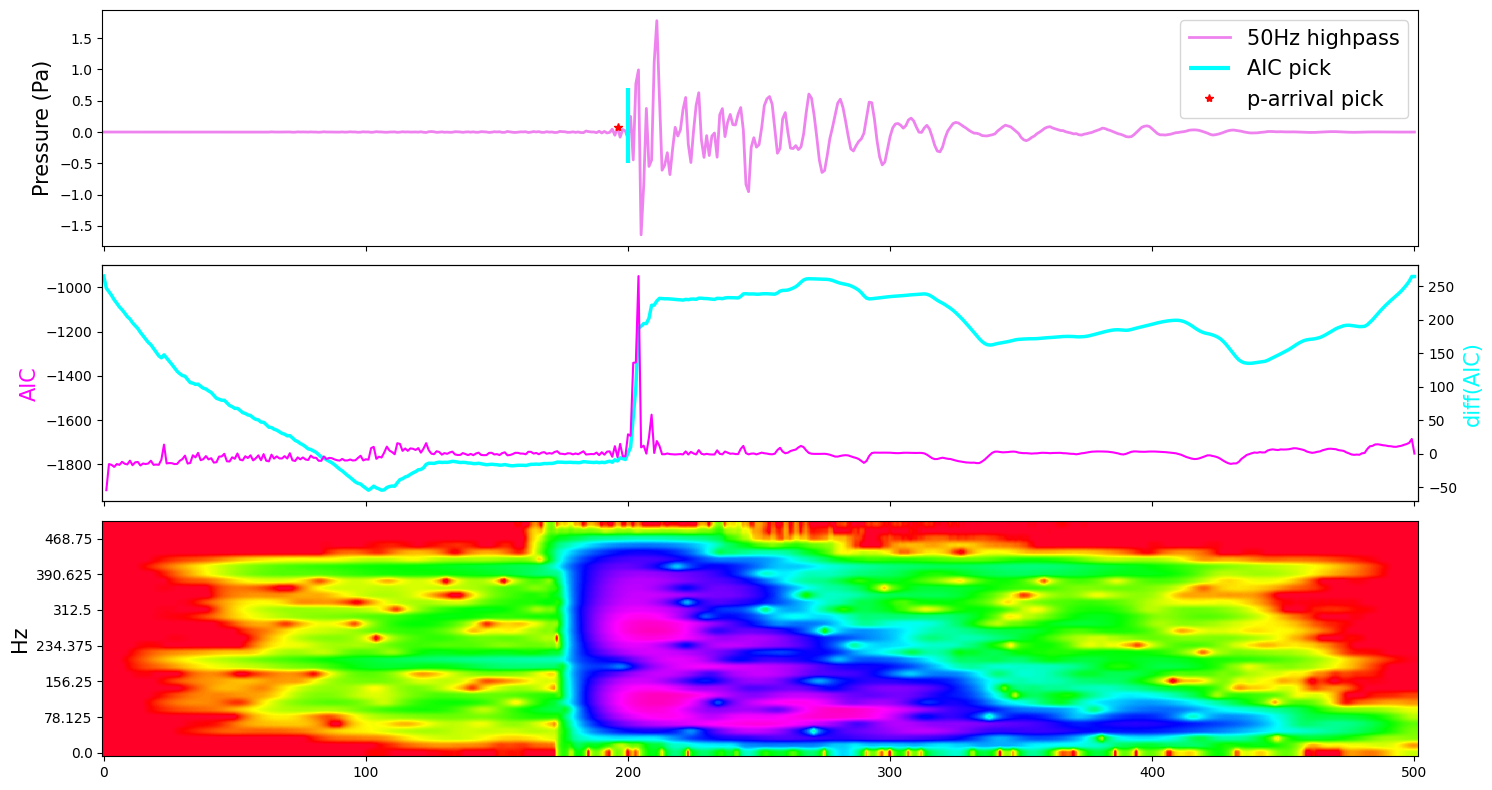

In [42]:
plot_event(event_id=136, day_number=141, df=df141)

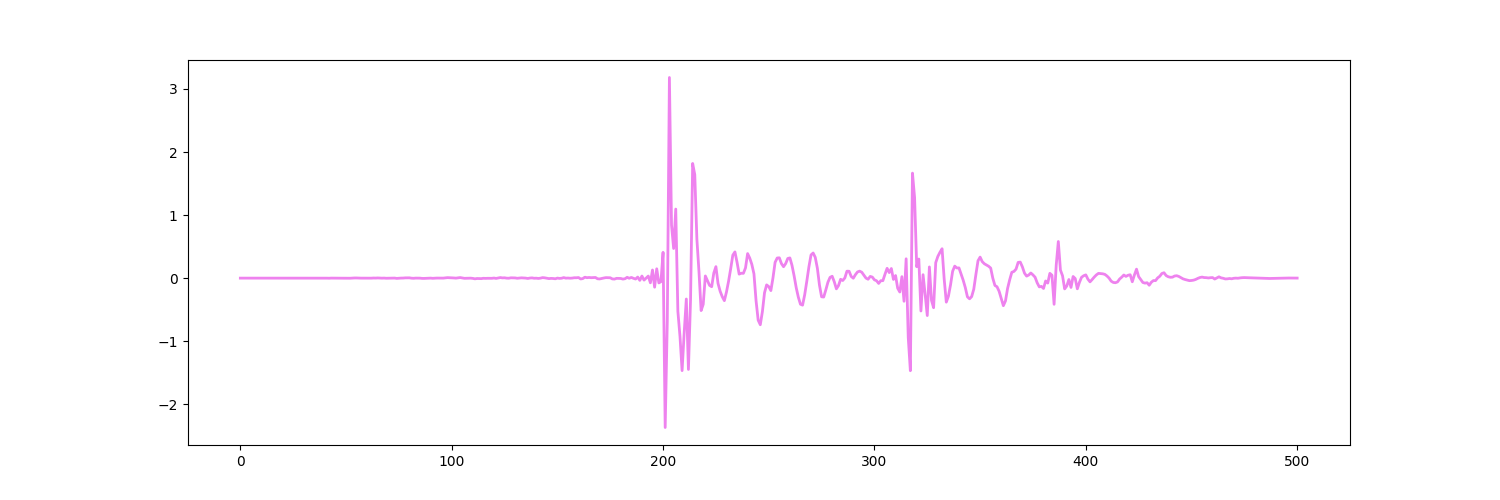

In [69]:
%matplotlib widget
fig, ax = plt.subplots(figsize=(15, 5))

e = get_event(event_id=1252, day_number=141, df=df141)
plot_50hz_highpass(event=e, ax=ax)

In [77]:
print('p-arrival time')
(e.starttime - 0.2) + 0.195

p-arrival time


2019-05-21T08:18:20.223000Z

In [70]:
obspy.UTCDateTime(dates.num2date(e.hphone1_time)) - (e.relative_depth / e.velocity_model)

2019-05-21T08:18:20.189000Z

In [71]:
obspy.UTCDateTime(dates.num2date(e.hphone1_time))

2019-05-21T08:18:20.228000Z

In [ ]:
print('

In [72]:
e.relative_depth

68.25

In [73]:
e.depth

308.25

In [13]:
# YOU NEED TO ADD THE P-WAVE PICKER

/var/folders/93/x6b4gbcn51sfzw4hllq1kt000000gn/T/ipykernel_17104/3398240477.py:16: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(x, y, s=s*10, alpha=0.3, c=plt.cm.twilight(0.4))
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


amplitude: 273.18656548251727
3545.5959999999936


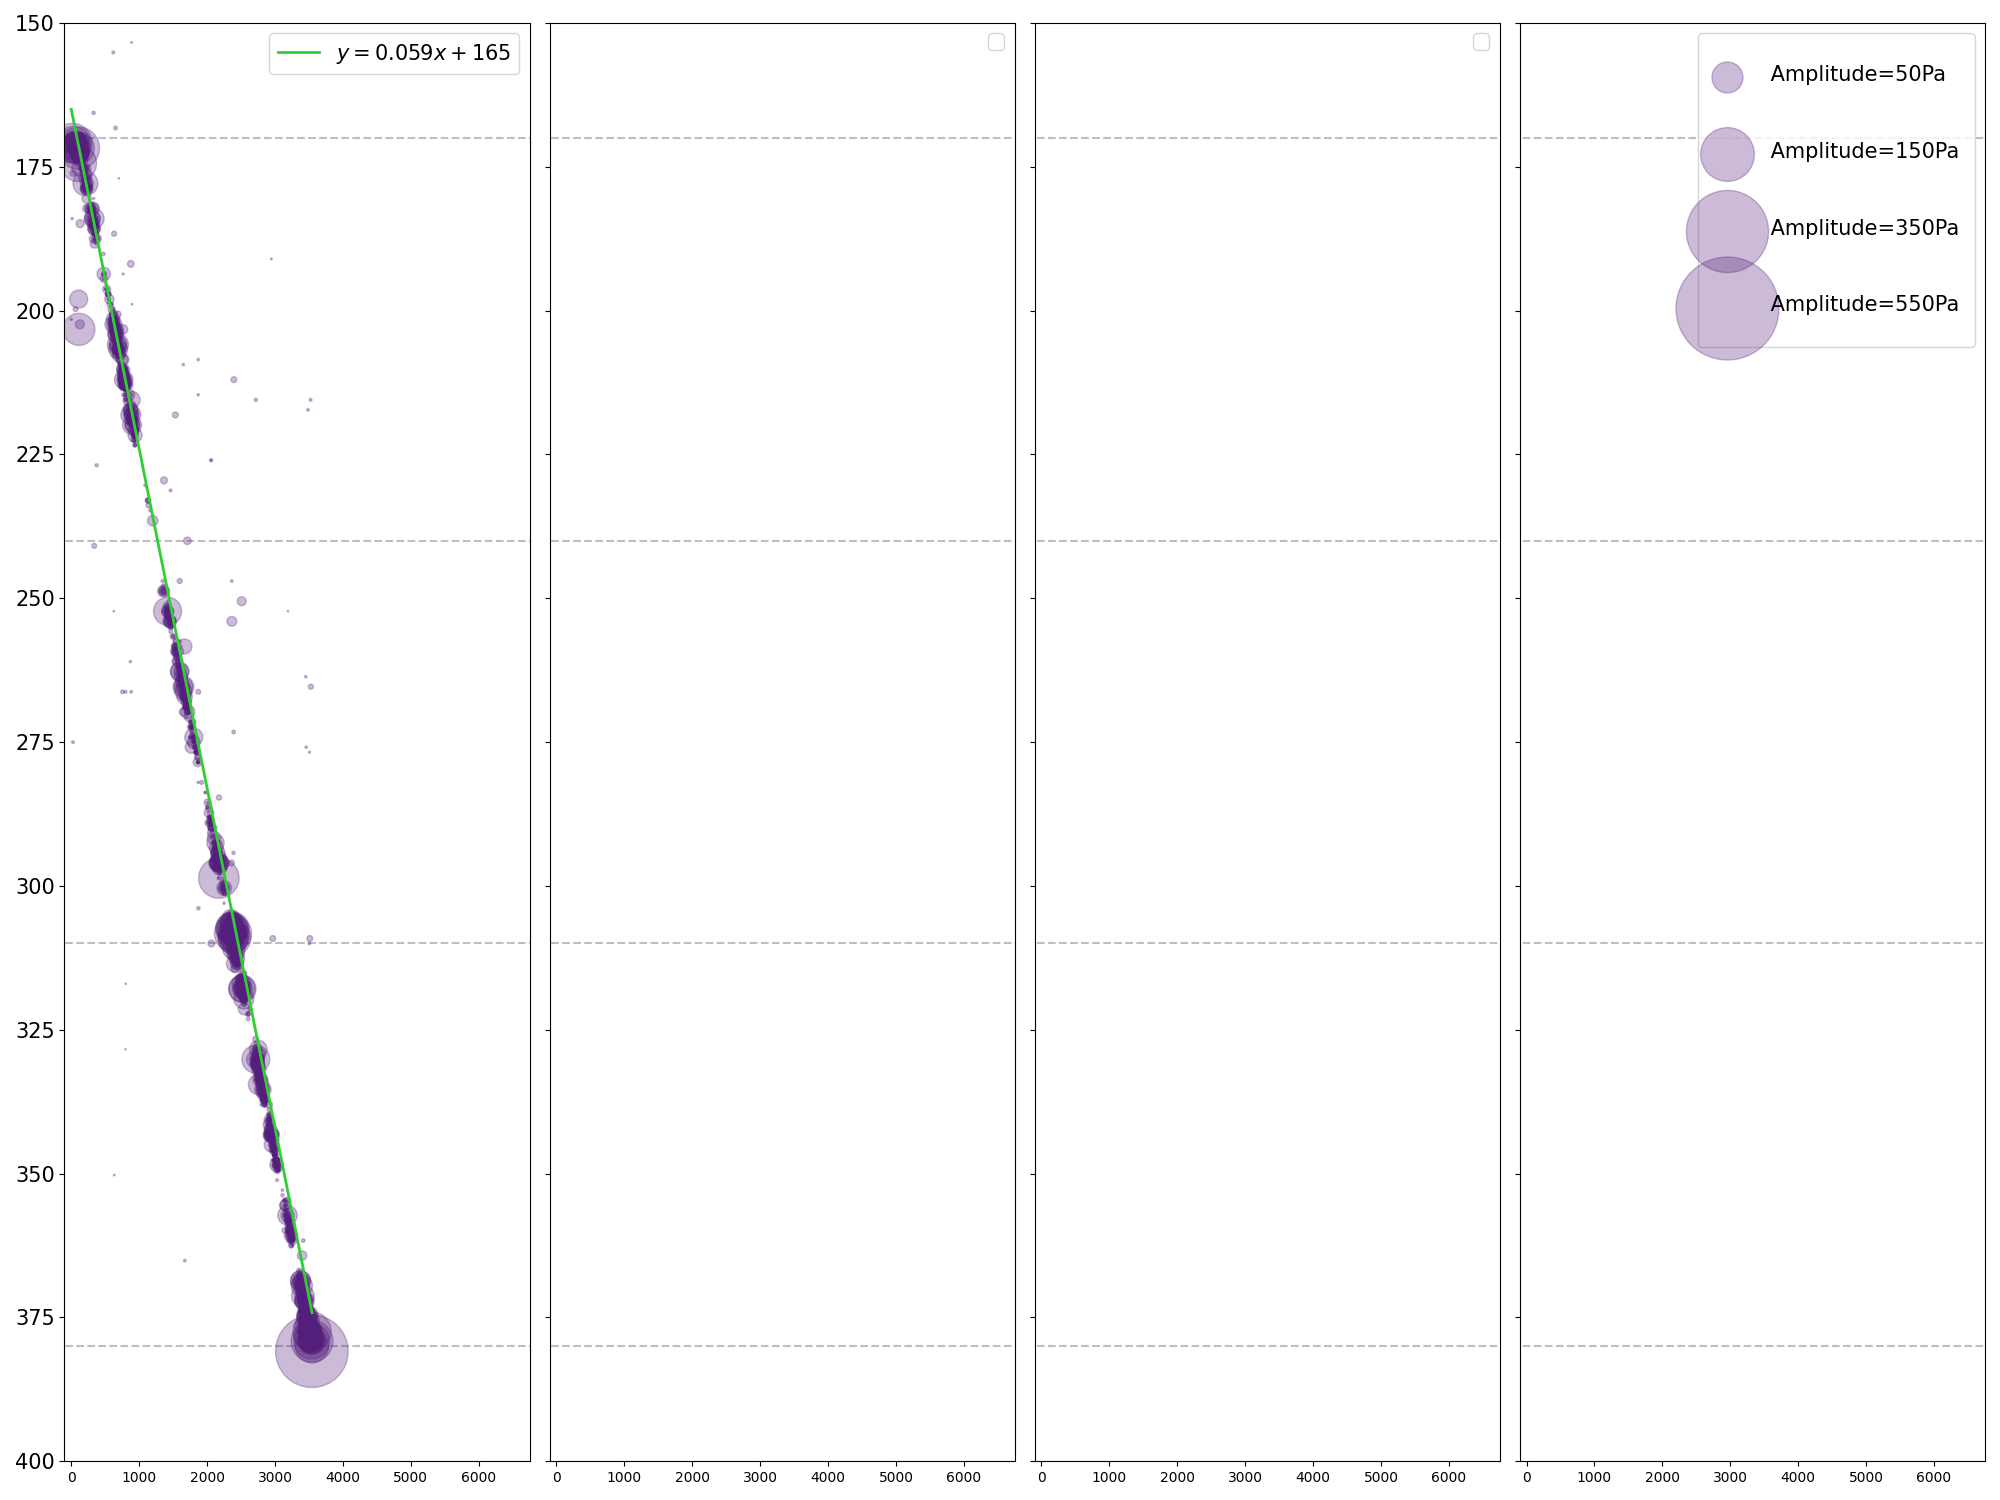

In [74]:
fig, ax = plt.subplots(1, 4, figsize=(20, 15), sharey=True, sharex=True)

ax[3].scatter([0], [0], s=[50*10,], alpha=0.3, color=plt.cm.twilight(0.4), label='\n Amplitude=50Pa \n')
ax[3].scatter([0], [0], s=[150*10,], alpha=0.3, color=plt.cm.twilight(0.4), label='\n Amplitude=150Pa \n')
ax[3].scatter([0], [0], s=[350*10,], alpha=0.3, color=plt.cm.twilight(0.4), label='\n Amplitude=350Pa \n')
ax[3].scatter([0], [0], s=[550*10,], alpha=0.3, color=plt.cm.twilight(0.4), label='\n Amplitude=550Pa \n')
ax[3].legend(fontsize=15, edgecolor='None')

def plot_events(data, ax):
    x = data['arrival_datetime'].diff().apply(lambda t: t.total_seconds()).fillna(0).cumsum().values
    y = data['depth'].values
    s = data['max_amp'].values
    print('amplitude:',s.max())
    print(x.max())
    # ax.scatter(x/x.max(), y, s=s*10, alpha=0.3, c=plt.cm.twilight(0.4))
    ax.scatter(x, y, s=s*10, alpha=0.3, c=plt.cm.twilight(0.4))
    return x.max()

def plot_best_fit_line(slope, intercept, ax, xstart=0, xend=1, **kwargs):
    x = np.linspace(xstart, xend, 1000)
    y = slope * x + intercept
    ax.plot(x, y, color='limegreen', linewidth=2, **kwargs)

def plot_hydrophone_depth_horizontal_line(hid, ax):
    hids = ['h1', 'h2', 'h3', 'h4', 'h5', 'h6']
    for hid in hids:
        depth = config.hydrophone_metadata_141[hid]['depth']
        ax.hlines(y=depth, xmin=-70000, xmax=700000, linestyle='--', color='black', alpha=0.25, zorder=0)

plot_hydrophone_depth_horizontal_line(hid='h3', ax=ax[0])
plot_hydrophone_depth_horizontal_line(hid='h4', ax=ax[1])
plot_hydrophone_depth_horizontal_line(hid='h5', ax=ax[2])
plot_hydrophone_depth_horizontal_line(hid='h6', ax=ax[3])
    
x141 = plot_events(data=df141, ax=ax[0])
# x188 = plot_events(data=df188, ax=ax[1])
# x197 = plot_events(data=df197, ax=ax[2])
# x211 = plot_events(data=df211, ax=ax[3])

plot_best_fit_line(slope=0.059, intercept=165
                   , ax=ax[0], xstart=0, xend=x141
                  , label=r'$y = 0.059 x + 165$')

# plot_best_fit_line(slope=0.071, intercept=115
#                    , ax=ax[1], xstart=0.2*x188, xend=0.8*x188
#                   , label=r'$y = 0.071 x + 115$')

# plot_best_fit_line(slope=0.069, intercept=100
#                    , ax=ax[1], xstart=1000, xend=4100
#                   ,linestyle='--', label=r'$y = 0.069x + 100$')

# plot_best_fit_line(slope=0.064, intercept=85
#                    , ax=ax[1], xstart=0.3*x188, xend=1*x188
#                   ,linestyle='-.', label=r'$y = 0.064x + 85$')

# plot_best_fit_line(slope=0.1, intercept=150
#                    , ax=ax[2], xstart=250, xend=2000
#                   ,label=r'$0.1 x + 150$')

# plot_best_fit_line(slope=0.066, intercept=-17
#                    , ax=ax[2], xstart=2800, xend=6000
#                   ,linestyle='--', label=r'$y = 0.066 x - 17$')

# plot_best_fit_line(slope=0.2, intercept=80
#                    , ax=ax[3], xstart=400, xend=1581
#                   ,label=r'$y = 0.2 x + 85$')

ax[0].set_yticks(np.arange(150, 425, 25))
ax[0].set_yticklabels(np.arange(150, 425, 25), fontsize=15)
ax[0].set_ylim(400, 150)
ax[0].set_xlim(-100, 6750)
fig.tight_layout()
ax[0].legend(fontsize=15)
ax[1].legend(fontsize=15)
ax[2].legend(fontsize=15)
ax[3].legend(fontsize=15)

# fig.savefig('figures/events.pdf')

In [15]:
# (e.starttime._get_datetime().replace(tzinfo=datetime.timezone.utc) - e.parrival).total_seconds()

In [16]:
# e.first_hydrophone_id

In [17]:
# dates.num2date(e.aic_t[4])

In [18]:
# e.starttime._get_datetime()